# **Data Processing**

After Loading the data, we must now process it in order to be able to use it in our model. For this we will follow the following steps:
1. Remove unnecessary columns
2. Handle the Date column on both datasets and unify the format
3. Join the datasets
4. Handle the missing values or rows (dates that are not present in both datasets) if any
5. Handle the categorical values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
# Load the datasets
df_energy = pd.read_csv('datasets/energy.csv',na_filter=False, encoding = "latin")
df_meteorology = pd.read_csv('datasets/meteorology.csv', na_filter=False, encoding = "latin")

### **Remove unnecessary columns**

In [3]:
# We can drop city_name, sea_level and grnd_level as they only have one unique value
df_meteorology = df_meteorology.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)

### **Handle the Date column on both datasets and unify the format**

Energy dataset:

In [4]:
# Convert columns to unified format
df_energy['datetime'] = pd.to_datetime(df_energy['Data'] + ' ' + df_energy['Hora'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')

# Drop the original 'Data' and 'Hora' columns
df_energy = df_energy.drop(['Data', 'Hora'], axis=1)

# Print the updated DataFrame
df_energy.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),datetime
901,0.0,0.0,0.274,Very High,2021-11-05 13:00:00


Meteorology dataset:

In [5]:
# Convert columns to unified format
df_meteorology['dt_iso'] = pd.to_datetime(df_meteorology['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
df_meteorology['dt_iso'] = df_meteorology['dt_iso'].dt.tz_localize(None)

# Rename the column to 'datetime'
df_meteorology = df_meteorology.rename(columns={"dt_iso": "datetime"})

# We can also drop the 'dt' column as it is redundant
df_meteorology = df_meteorology.drop(['dt'], axis=1)

# Print the updated DataFrame
df_meteorology.iloc[801].to_frame().T

,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
801,2021-10-04 09:00:00,14.03,13.84,13.34,14.54,1023,90,2.07,,69,broken clouds


Validating the dates:

In [6]:
# Order the dataframes by datetime so we can detect any time skips
df_energy = df_energy.sort_values(by=['datetime'])
df_meteorology = df_meteorology.sort_values(by=['datetime'])

In [7]:
time_diff_en = df_energy['datetime'].diff()
time_diff_me = df_meteorology['datetime'].diff()

# Print the irregular time intervals
irregularities_en = time_diff_en[time_diff_en != '0 days 01:00:00']
irregularities_me = time_diff_me[time_diff_me != '0 days 01:00:00']
print("Irregular time intervals in df_en:")
print(irregularities_en)
print("\n")
print("Irregular time intervals in df_me:")
print(irregularities_me)

Irregular time intervals in df_en:
0   NaT
Name: datetime, dtype: timedelta64[ns]


Irregular time intervals in df_me:
0   NaT
Name: datetime, dtype: timedelta64[ns]


### **Rename columns**

In [8]:
# Rename Injeção na rede (kWh) to Injection
df_energy = df_energy.rename(columns={'Injeção na rede (kWh)': 'Injection'})

# Rename the Portuguese Columns to English (Injeção na rede (kWh), Horário Económico (kWh), Autoconsumo (kWh)
df_energy = df_energy.rename(columns={'Horário Económico (kWh)': 'Economic (kWh)', 'Autoconsumo (kWh)': 'Self-consumption (kWh)'})

df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Normal (kWh)            11016 non-null  float64       
 1   Economic (kWh)          11016 non-null  float64       
 2   Self-consumption (kWh)  11016 non-null  float64       
 3   Injection               11016 non-null  object        
 4   datetime                11016 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 430.4+ KB


### **Join the datasets**

Outer join:

In [9]:
outer_join_merged_df = pd.merge(df_energy, df_meteorology, on='datetime', how='outer')

In [10]:
outer_join_merged_df.isna().sum()

Normal (kWh)              672
Economic (kWh)            672
Self-consumption (kWh)    672
Injection                 672
datetime                    0
temp                        0
feels_like                  0
temp_min                    0
temp_max                    0
pressure                    0
humidity                    0
wind_speed                  0
rain_1h                     0
clouds_all                  0
weather_description         0
dtype: int64

Given that the datetime data exhibits no irregularities, the additional entries found in the Weather dataset but not in the Energy dataset can be attributed to the Weather dataset containing data from days before or after the Energy dataset's first or last entry, respectively. A manual analysis of the datasets reveals that the Weather dataset includes entries starting from 2021-09-01, while the Energy dataset commences from 2021-09-29. Consequently, we have only one viable option. Since the Energy dataset contains the labeled data, we must take the following approach:

- We need to exclude entries from the Weather dataset that precede 2021-09-29, as they will not contribute to the modeling process. To achieve this, we will perform an Inner Join between the two datasets on the datetime column. The resulting dataset from this operation will be the one we use moving forward.

Inner join:

In [11]:
merged_df = pd.merge(df_energy, df_meteorology, on='datetime', how='inner')

In [12]:
merged_df.isna().sum()

Normal (kWh)              0
Economic (kWh)            0
Self-consumption (kWh)    0
Injection                 0
datetime                  0
temp                      0
feels_like                0
temp_min                  0
temp_max                  0
pressure                  0
humidity                  0
wind_speed                0
rain_1h                   0
clouds_all                0
weather_description       0
dtype: int64

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Normal (kWh)            11016 non-null  float64       
 1   Economic (kWh)          11016 non-null  float64       
 2   Self-consumption (kWh)  11016 non-null  float64       
 3   Injection               11016 non-null  object        
 4   datetime                11016 non-null  datetime64[ns]
 5   temp                    11016 non-null  float64       
 6   feels_like              11016 non-null  float64       
 7   temp_min                11016 non-null  float64       
 8   temp_max                11016 non-null  float64       
 9   pressure                11016 non-null  int64         
 10  humidity                11016 non-null  int64         
 11  wind_speed              11016 non-null  float64       
 12  rain_1h                 11016 non-null  object

### **Handling Categorical Values**

In [14]:
# Convert the 'rain_1h' column to numeric and replace empty values with 0
merged_df['rain_1h'] = pd.to_numeric(merged_df['rain_1h'].replace('', '0'))

In [15]:
weather_description_counts = merged_df['weather_description'].value_counts()
print(weather_description_counts)

weather_description
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64


In [16]:
# Perform One-Hot Encoding for 'weather_description'
merged_df = pd.get_dummies(merged_df, columns=['weather_description'], prefix='weather')

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  11016 non-null  float64       
 1   Economic (kWh)                11016 non-null  float64       
 2   Self-consumption (kWh)        11016 non-null  float64       
 3   Injection                     11016 non-null  object        
 4   datetime                      11016 non-null  datetime64[ns]
 5   temp                          11016 non-null  float64       
 6   feels_like                    11016 non-null  float64       
 7   temp_min                      11016 non-null  float64       
 8   temp_max                      11016 non-null  float64       
 9   pressure                      11016 non-null  int64         
 10  humidity                      11016 non-null  int64         
 11  wind_speed                  

# **Visualizations on the modified data**

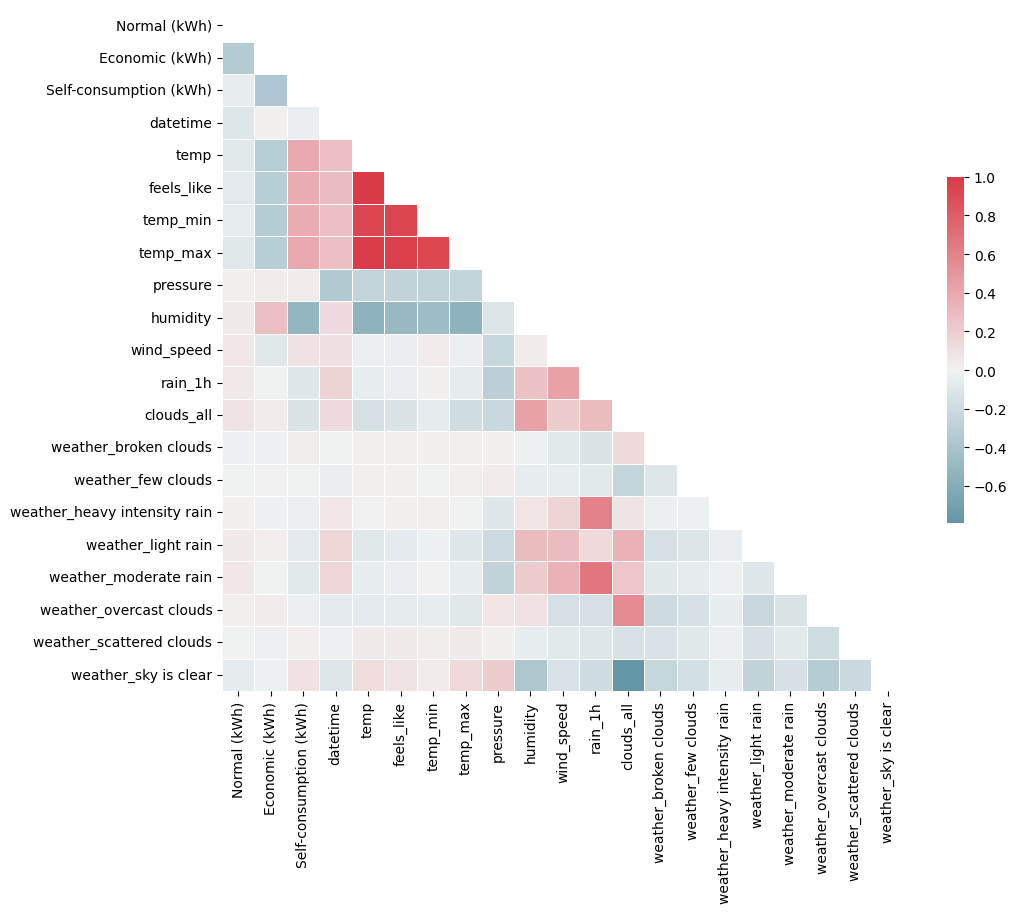

In [18]:
# Create a Correlation Matrix with the possible features and exclude 'Injection'
corr = merged_df.drop(['Injection'], axis=1).corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.zeros_like(corr, dtype=bool)  # Use bool instead of np.bool

mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Display the plot
plt.show()


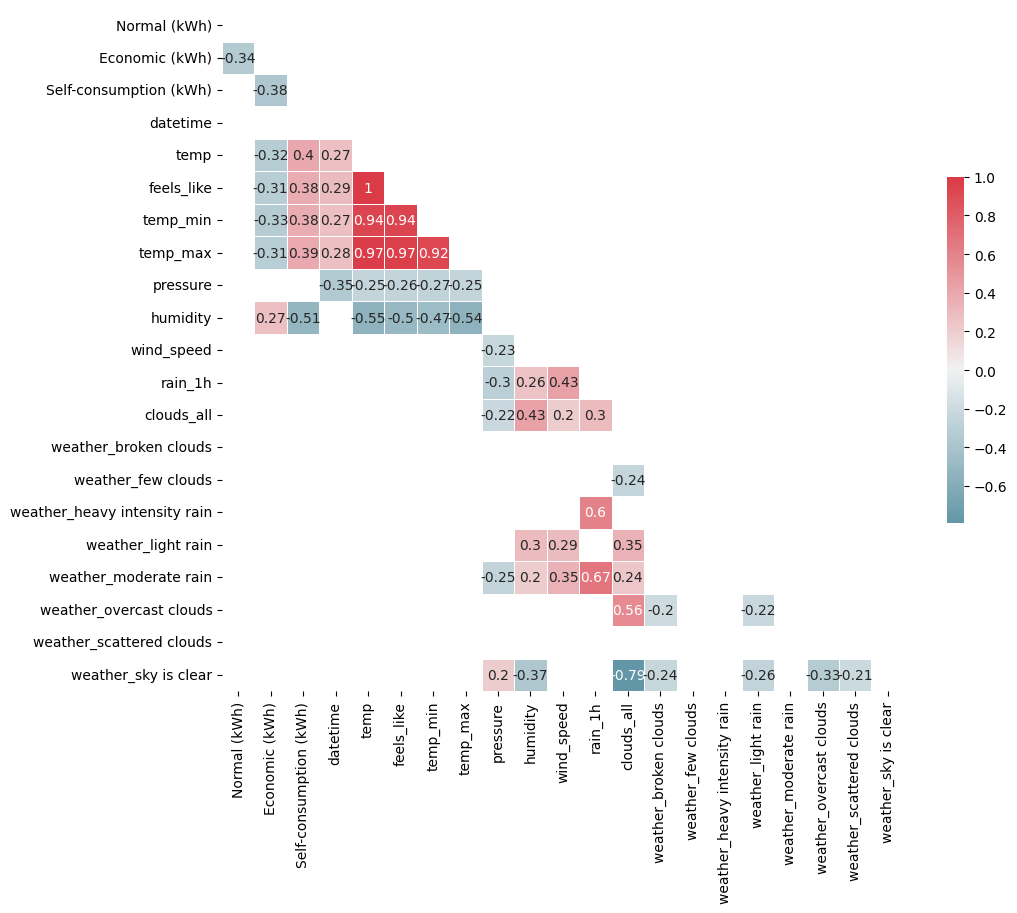

In [19]:
# Set the correlation threshold
correlation_threshold = 0.2  # You can adjust this value

# Filter correlations above the threshold
high_corr = corr[((corr > correlation_threshold) | (corr < -correlation_threshold)) & (corr != 1)]

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(high_corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Display the plot
plt.show()


In [20]:
# Dividing the datetime into more features
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['day'] = merged_df['datetime'].dt.day
merged_df['hour'] = merged_df['datetime'].dt.hour


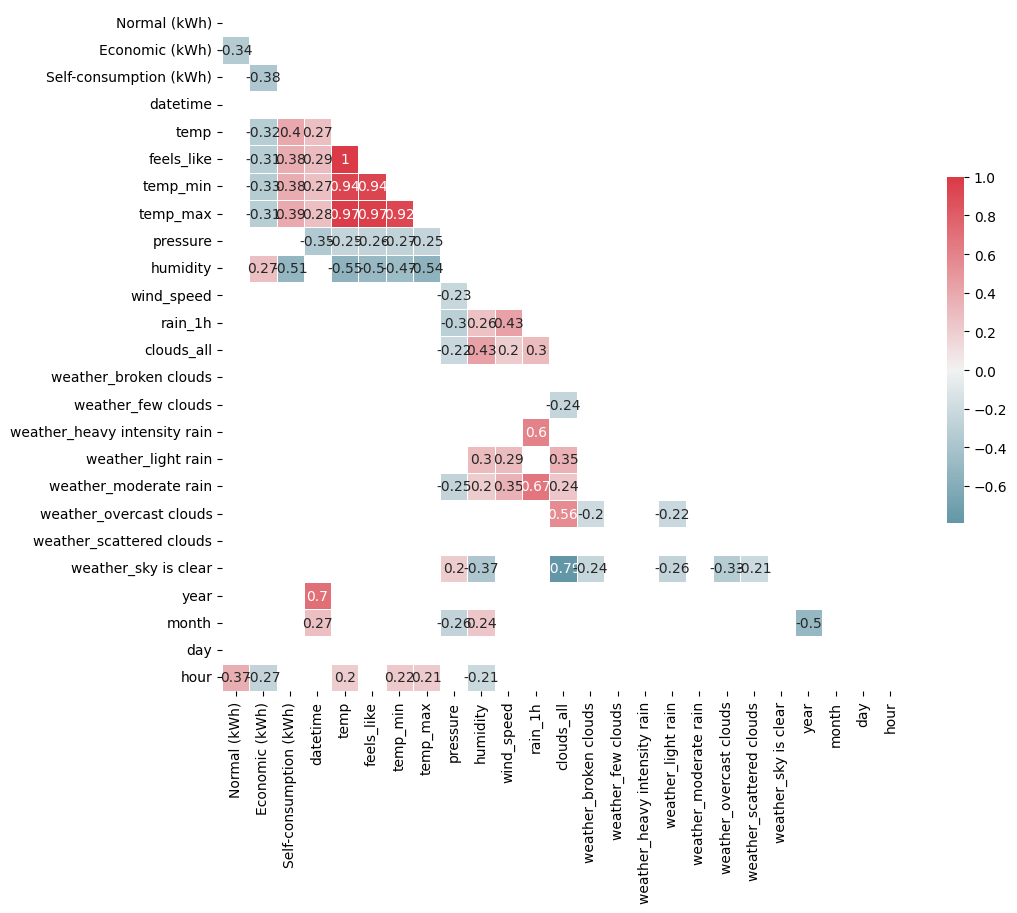

In [21]:
# Drop 'Injection'
corr = merged_df.drop(['Injection'], axis=1).corr()

# Set the correlation threshold
correlation_threshold = 0.2  # You can adjust this value

# Filter correlations above the threshold
high_corr = corr[((corr > correlation_threshold) | (corr < -correlation_threshold)) & (corr != 1)]

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(high_corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Display the plot
plt.show()

When we divided the datetime into its components we noticed that the year is not relevant to our model, as we only have data from 2 years, therefore we will drop it. One other thing we noticed is that the month is somewhat relevant but it might be more useful to have the day of the year instead. We will keep the Hour as it seems to be the most relevant feature and it is coherent with the common sense, as we know that the energy consumption is higher during the day and lower during the night.

In [22]:
# Drop the 'year' column
merged_df = merged_df.drop(['year'], axis=1)

# Transform the month and day into day of year
merged_df['day_of_year'] = merged_df['datetime'].dt.dayofyear

# Drop the 'month' and 'day' columns as well as the 'datetime' column
merged_df = merged_df.drop(['month', 'day', 'datetime'], axis=1)

In [23]:
# Print the updated DataFrame
merged_df.iloc[801].to_frame().T

,Normal (kWh),Economic (kWh),Self-consumption (kWh),Injection,temp,feels_like,temp_min,temp_max,pressure,humidity,...,weather_broken clouds,weather_few clouds,weather_heavy intensity rain,weather_light rain,weather_moderate rain,weather_overcast clouds,weather_scattered clouds,weather_sky is clear,hour,day_of_year
801,0.314,0.0,0.196,None,13.05,12.87,11.45,15.11,1018,94,...,True,False,False,False,False,False,False,False,9,305


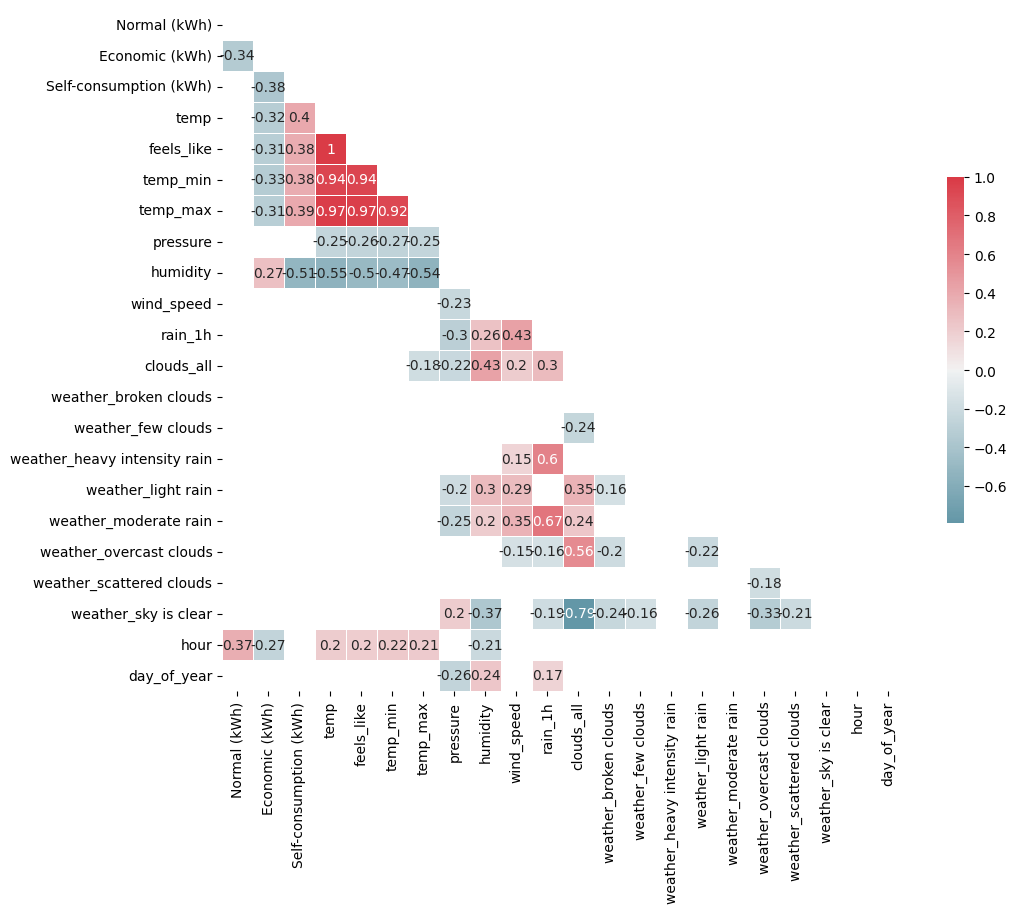

In [24]:
# Drop 'Injection'
corr = merged_df.drop(['Injection'], axis=1).corr()

# Set the correlation threshold
correlation_threshold = 0.15  # You can adjust this value

# Filter correlations above the threshold
high_corr = corr[((corr > correlation_threshold) | (corr < -correlation_threshold)) & (corr != 1)]

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(high_corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Display the plot
plt.show()


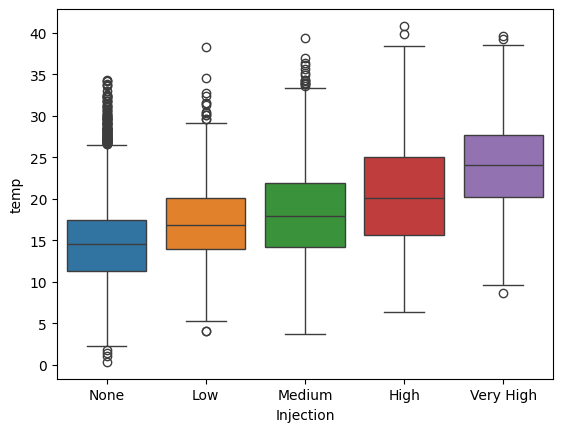

In [25]:
# Boxplot of 'temp' grouped by 'Injection'
sns.boxplot(x='Injection', y='temp', hue='Injection', data=merged_df)
plt.show()

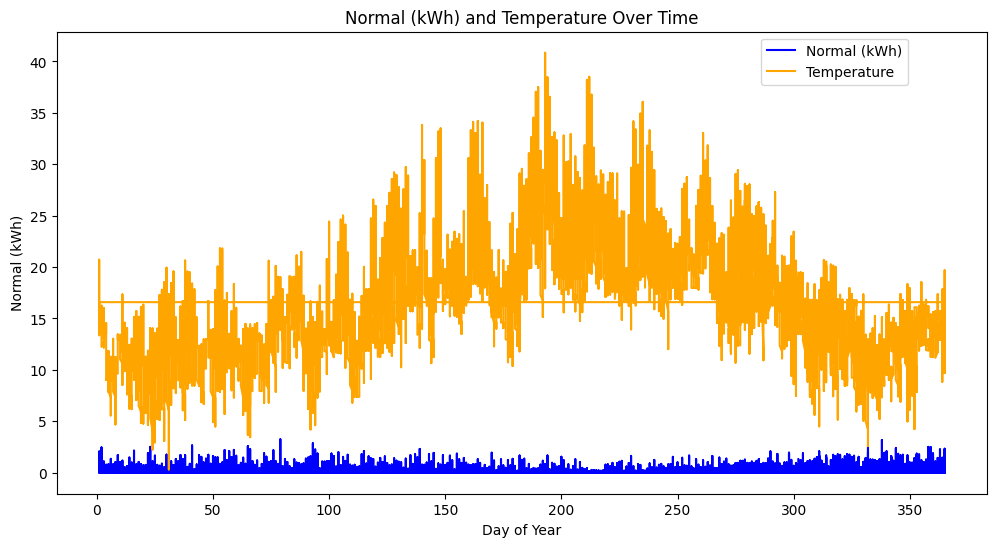

In [26]:
# Plotting 'Normal (kWh)' and 'Temperature' against 'day_of_year'
plt.figure(figsize=(12, 6))

# Plot 'Normal (kWh)'
plt.plot(merged_df['day_of_year'], merged_df['Normal (kWh)'], label='Normal (kWh)', color='blue')

# Plot 'Temperature' on a secondary y-axis
plt.plot(merged_df['day_of_year'], merged_df['temp'], label='Temperature', color='orange')

# Add labels and legend
plt.xlabel('Day of Year')
plt.ylabel('Normal (kWh)')
plt.title('Normal (kWh) and Temperature Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(0.75, 1.0))

# Display the plot
plt.show()

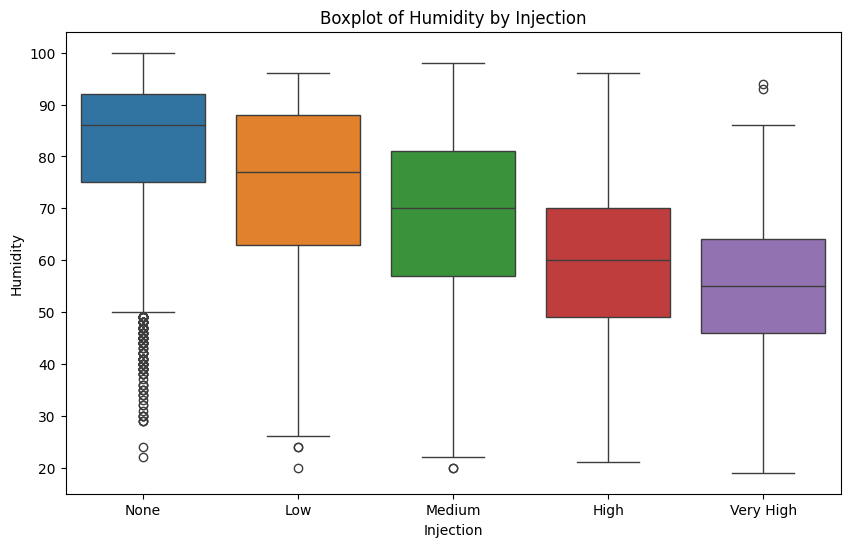

In [27]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Injection', y='humidity', hue='Injection', data=merged_df)

# Add labels and title
plt.xlabel('Injection')
plt.ylabel('Humidity')
plt.title('Boxplot of Humidity by Injection')

# Display the plot
plt.show()

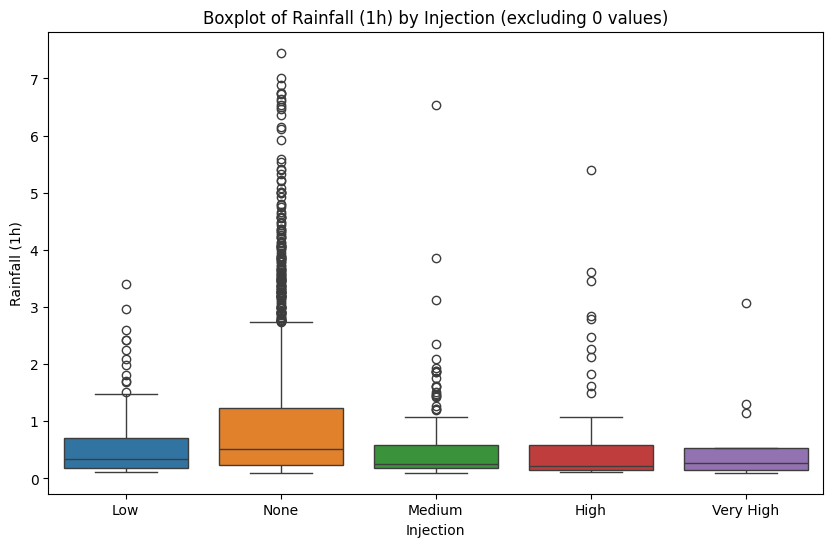

In [28]:
# Filter data to exclude rain_1h values equal to 0
filtered_data = merged_df[merged_df['rain_1h'] > 0]

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Injection', y='rain_1h', hue='Injection', data=filtered_data)

# Add labels and title
plt.xlabel('Injection')
plt.ylabel('Rainfall (1h)')
plt.title('Boxplot of Rainfall (1h) by Injection (excluding 0 values)')

# Display the plot
plt.show()

As the rain_1h column has too many distinct values, we will change it to a binary column, where 0 means no rain and 1 means rain.

In [29]:
# Convert 'rain_1h' to binary (1 for rain, 0 for no rain)
merged_df['rain_binary'] = merged_df['rain_1h'].apply(lambda x: 1 if x > 0 else 0)

# Convert rain_binary to boolean
merged_df['rain_binary'] = merged_df['rain_binary'].astype(bool)

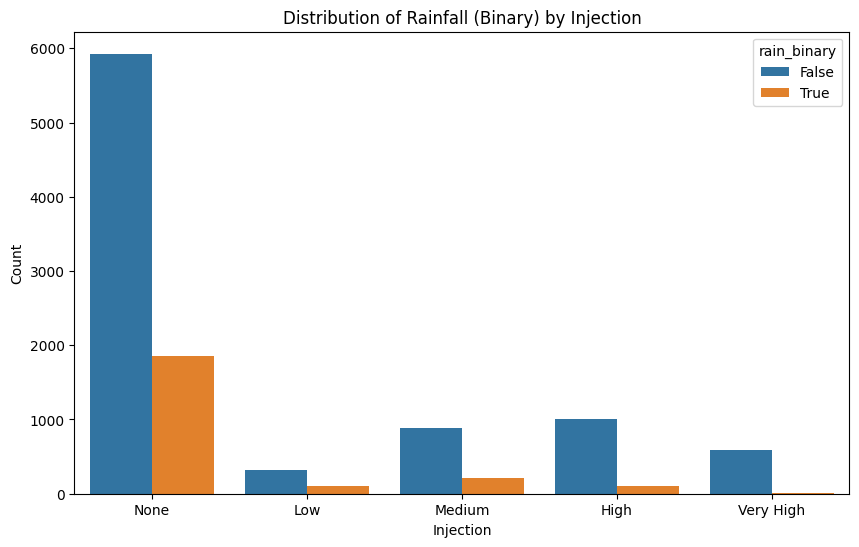

In [30]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Injection', hue='rain_binary', data=merged_df)

# Add labels and title
plt.xlabel('Injection')
plt.ylabel('Count')
plt.title('Distribution of Rainfall (Binary) by Injection')

# Display the plot
plt.show()

This feature may not be very relevant to our model, but we will keep it for now.

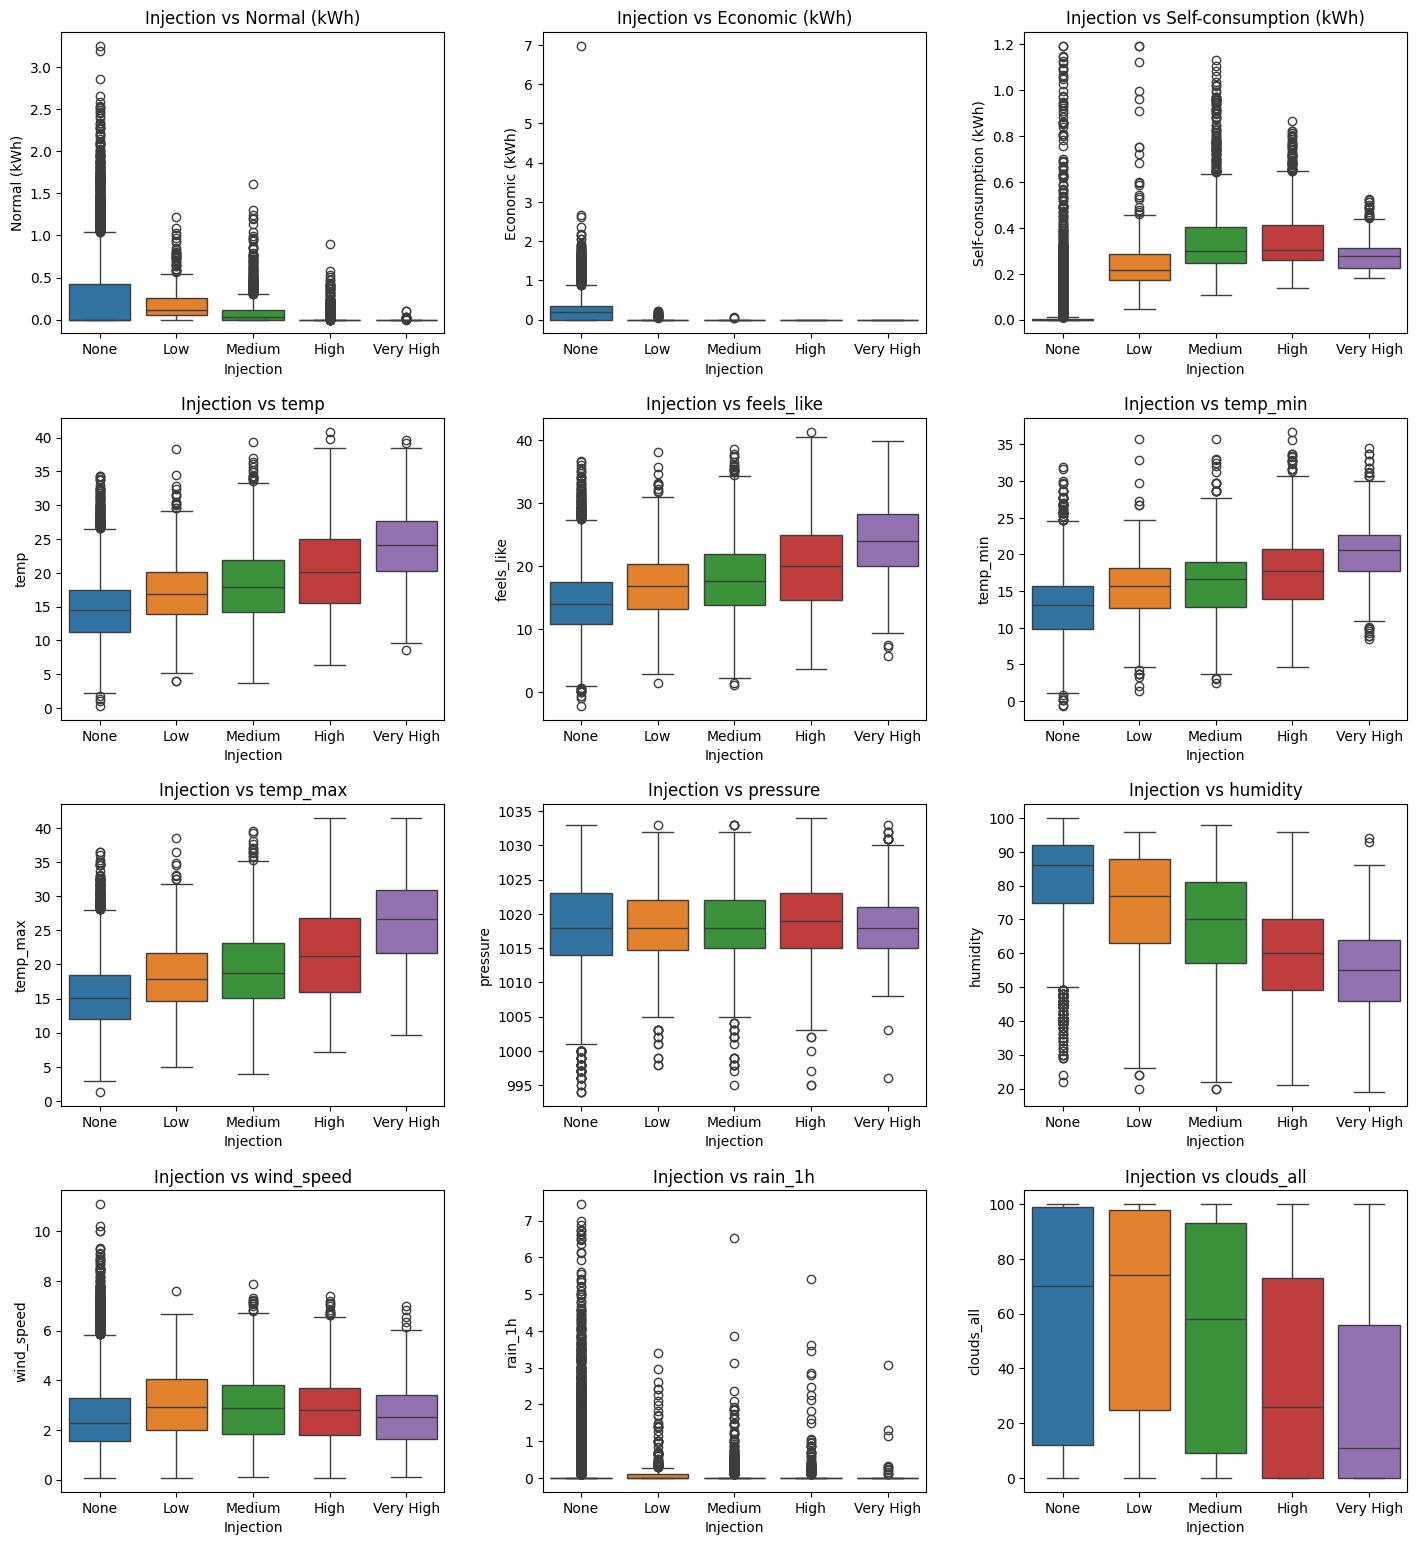

In [31]:
# Specify the columns you want to visualize
columns_to_visualize = ['Normal (kWh)', 'Economic (kWh)', 'Self-consumption (kWh)', 'temp', 'feels_like',
                         'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']

# Set up subplots with multiple columns
num_columns = 3  # You can adjust the number of columns as per your preference
num_rows = -(-len(columns_to_visualize) // num_columns)  # Ceiling division to determine the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 4 * num_rows))
fig.tight_layout(pad=4.0)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Create individual plots for each column
for i, column in enumerate(columns_to_visualize):
    ax = axes[i]
    sns.boxplot(x='Injection', y=column, data=merged_df, ax=ax, hue='Injection')
    ax.set_title(f'Injection vs {column}')
    ax.set_xlabel('Injection')
    ax.set_ylabel(column)

# Remove empty subplots if needed
for i in range(len(columns_to_visualize), len(axes)):
    fig.delaxes(axes[i])

plt.show()

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Normal (kWh)                  11016 non-null  float64
 1   Economic (kWh)                11016 non-null  float64
 2   Self-consumption (kWh)        11016 non-null  float64
 3   Injection                     11016 non-null  object 
 4   temp                          11016 non-null  float64
 5   feels_like                    11016 non-null  float64
 6   temp_min                      11016 non-null  float64
 7   temp_max                      11016 non-null  float64
 8   pressure                      11016 non-null  int64  
 9   humidity                      11016 non-null  int64  
 10  wind_speed                    11016 non-null  float64
 11  rain_1h                       11016 non-null  float64
 12  clouds_all                    11016 non-null  int64  
 13  w

In [33]:
merged_df.describe()

,Normal (kWh),Economic (kWh),Self-consumption (kWh),temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,hour,day_of_year
count,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000,11016.000000
mean,0.202278,0.159714,0.117314,16.182991,15.826868,14.195064,17.288098,1018.396605,76.570715,2.672039,0.185905,54.000908,11.500000,210.749455
std,0.349478,0.271792,0.176762,5.756972,6.264860,4.956014,6.164689,6.203379,16.268260,1.476158,0.611241,40.553002,6.922501,109.408739
min,0.000000,0.000000,0.000000,0.320000,-2.190000,-0.640000,1.330000,994.000000,19.000000,0.060000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,12.080000,11.507500,10.720000,12.890000,1015.000000,66.000000,1.620000,0.000000,7.000000,5.750000,115.000000
50%,0.000000,0.000000,0.000000,15.625000,15.230000,14.230000,16.260000,1018.000000,81.000000,2.400000,0.000000,60.000000,11.500000,230.000000
75%,0.314000,0.288000,0.227000,19.270000,19.260000,17.490000,20.340000,1022.000000,91.000000,3.420000,0.000000,98.000000,17.250000,308.000000
max,3.251000,6.978000,1.192000,40.850000,41.330000,36.720000,41.450000,1034.000000,100.000000,11.100000,7.450000,100.000000,23.000000,365.000000


In [34]:
# Write the merged DataFrame to a CSV file
merged_df.to_csv('datasets/merged.csv', index=False, encoding='latin')